Preprocessing was done in "Prelim_analysis" notebook and saved locally because of size constraints. It's reloaded here and BOW and TFIDF is rerun. 

In [6]:
#ToDo:
#Feature Extraction: Word2Vec, Doc2Vec
#Imbalanced Classes
#Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
full_preprocessed_train = pd.DataFrame(pd.read_csv(os.getcwd() + '/' + 'full_preprocessed_train.csv', sep=','))

In [10]:
X_train = full_preprocessed_train.drop(['label'], axis=1)
y_train = full_preprocessed_train['label']

### Feature Extraction

We have used unigram presence, unigram frequency, bigram presence, bigram frequency and review
length as features for our model. (http://www.ijceronline.com/papers/Vol5_issue5/J055052056.pdf)

We can test which works best:

- Count Vectorizer

Counts number of occurance of each words in vocabulary base. Transforms each review into a feature with vocabulary base. Now we can use any ML model we want. 

Cons: only the occurance of the words not the meaning is taken into consideration aka order ignorant. 

- Tfidf

- Word2Vec

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

***Count Vectorizer***

In [12]:
X_train = X_train.replace(np.nan, " ")

In [13]:
#CountVectorizer
binary_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words='english')

In [14]:
binary_vectorizer.fit(X_train['review'])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [15]:
X_train_binary = binary_vectorizer.transform(X_train['review'])

In [16]:
X_train_binary

<250874x4153723 sparse matrix of type '<class 'numpy.int64'>'
	with 23844943 stored elements in Compressed Sparse Row format>

***TFIDF Vectorizer***

In [17]:
#TfidfVectorizer
binary_Tfidf_vectorizer = TfidfVectorizer(binary=True, ngram_range=(1, 2), stop_words='english')
binary_Tfidf_vectorizer.fit(X_train['review'])
list(binary_Tfidf_vectorizer.vocabulary_.keys())[0:10]
binary_Tfidf_vectorizer.get_feature_names()[0:10]

#stores data in sparse matrix
X_train_binary_Tfidf = binary_Tfidf_vectorizer.transform(X_train['review'])

In [18]:
X_train_binary_Tfidf

<250874x4153723 sparse matrix of type '<class 'numpy.float64'>'
	with 23844943 stored elements in Compressed Sparse Row format>

***Doc2Vec***

The goal of doc2vec is to create a numeric representation of a document, regardless of its length. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document. Default vector size is 100 for each document. 

`min_count`: Ignores all words with total frequency lower than this.

`epochs`: number of iterations over the corpus (ie. number of times to train)

https://radimrehurek.com/gensim/models/word2vec.html

https://towardsdatascience.com/implementing-multi-class-text-classification-with-doc2vec-df7c3812824d

https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e

https://arxiv.org/pdf/1405.4053v2.pdf

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.test.utils import common_texts, get_tmpfile

In [6]:
#tokenized data required for Word2Vec & Doc2Vec
def tokenize(data):
    
    data = data.replace(np.nan, " ")
    #tokenize reviews and store in separate column for vectorizers
    data['tokens'] = pd.Series()
    for i in range(len(data['review'])):
        data['tokens'][i] = word_tokenize(data['review'][i])
    
    return data

In [20]:
train = tokenize(full_preprocessed_train) #15min

In [ ]:
#tokenize test data
#test = tokenize(test)

In [11]:
def Doc2Vec_input(data):
    
    #returns appropriate input data for Doc2Vec model
    #tag reviews with tokens and labels
    train_doc =[]
    for i in range(0,data.shape[0]):
        train_doc.append(TaggedDocument(data['tokens'][i],str(data['label'][i]))) 
    
    return train_doc

In [150]:
train_doc = Doc2Vec_input(train)

In [249]:
#example input
train_doc[0]

TaggedDocument(words=['food', 'snack', 'selection', 'popular', 'greek', 'dishes', 'appetizer', 'tray', 'good', 'greek', 'salad', 'underwhelmed', 'main', 'courses', 'tables', 'sometimes', 'hard', 'get', 'seated'], tags='1')

In [ ]:
#will need to create inputs for test data
#test_doc = Doc2Vec_input(test)

In [158]:
def Doc2Vec_train_model(train_doc, min_count=50,epochs=1):
    
    #trains Doc2Vec model
    dv_model = Doc2Vec(min_count = min_count)
    vocabulary = dv_model.build_vocab([x for x in train_doc])
    dv_model.train(train_doc,total_examples=len(train_doc), epochs=epochs)
    dv_model.save('dv_model')
    
    return dv_model

In [159]:
#train Doc2Vec model
dv_model = Doc2Vec_train_model(train_doc, min_count = 50, epochs =1)

In [13]:
def Doc2Vec_vectorize(model, data, epochs=1):
    
    #creates feature vectors for each review
    targets, feature_vectors = zip(*[(doc.tags[0], dv_model.infer_vector(doc.words, epochs =epochs)) for doc in data])
    return np.array(feature_vectors)

In [7]:
#load saved model
dv_model = Doc2Vec.load('dv_model')

In [163]:
#create feature vectors for each review
dv_train = Doc2Vec_vectorize(dv_model,train_doc)

In [248]:
#example output
dv_train[0]

0        -0.012734
1        -0.015634
2        -0.023918
3        -0.062335
4        -0.024757
            ...   
250869   -0.130706
250870   -0.067054
250871   -0.094647
250872   -0.057631
250873   -0.408347
Name: 0, Length: 250874, dtype: float64

In [24]:
#export Doc2Vec features as matrix so we don't need to run again
#np.savetxt("dv_train.csv", dv_train, delimiter=",")
#import saved train feature matrix
dv_train = pd.DataFrame(pd.read_csv('dv_train.csv',header = None))

In [85]:
#create feature vectors for test data using trained model
#dv_test = Doc2Vec_vectorize(dv_model, test_doc)

***Validation Set Performance on just Doc2Vec features***

In [8]:
val = pd.DataFrame(pd.read_csv('full_preprocessed_dev.csv'))

In [9]:
val = tokenize(val)

In [14]:
val_doc = Doc2Vec_input(val)
dv_val = Doc2Vec_vectorize(dv_model,val_doc)

In [15]:
np.savetxt("dv_val.csv", dv_val, delimiter=",")

In [16]:
dv_val = pd.DataFrame(pd.read_csv('dv_val.csv',header = None))

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
dv_val.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.024378,-0.011341,0.027830,-0.016577,0.011663,0.015205,-0.012754,0.014530,0.002192,-0.005236,...,0.003278,-0.005965,0.014563,0.021086,-0.005711,-0.006272,0.003670,-0.009553,-0.003387,0.002644
1,-0.100917,-0.008375,-0.040776,-0.054291,0.059100,-0.001957,-0.006223,0.004100,-0.003742,0.039506,...,-0.017508,-0.002470,-0.012271,-0.033159,-0.042549,-0.021927,-0.014873,0.026018,-0.007107,-0.014034
2,-0.226908,-0.077797,-0.024650,-0.033738,0.040448,-0.131478,0.044563,0.086871,-0.040652,0.028787,...,-0.065935,-0.053869,0.152316,-0.057749,-0.133364,-0.058168,0.091313,-0.036903,0.071645,0.043426
3,-0.028902,-0.031812,0.005154,0.000457,0.032092,-0.009865,0.005364,0.001181,-0.052542,-0.029562,...,-0.000919,0.009804,0.055477,-0.011842,-0.017485,-0.044842,-0.024257,-0.043243,0.032026,0.066152
4,-0.062493,0.000413,-0.005998,-0.113533,0.046913,-0.007696,0.013374,-0.011959,0.021428,0.020432,...,-0.062944,0.024767,0.014776,-0.008454,0.004320,0.053754,0.038958,0.004754,0.037695,-0.035619


In [21]:
y_train = train['label']
y_val = val['label']

In [25]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(dv_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
y_pred = logreg.predict(dv_val)

In [27]:
from sklearn.metrics import accuracy_score, f1_score

In [28]:
print('Testing accuracy: {}'.format(accuracy_score(y_val, y_pred)))
print('Testing F1 score: {}'.format(f1_score(y_val, y_pred, average='weighted')))

Testing accuracy: 0.898435324906732
Testing F1 score: 0.8503697992239174


***LDA***

Topic modeling which is based on co-occurences of words within topics.

Might want to play around with num_topics. HDP used to find num_topics but now its max is 150. Tried LDA with 100 topics, try different number of top topics for which the feature vectors are built on (ie. 100 topics, but only using 20 topics to be assigned to feature vectors).

https://radimrehurek.com/gensim/models/ldamodel.html

https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [31]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [39]:
def LDA_input(data):
    #create bag of words corpus and dictionary
    dictionary = corpora.Dictionary(data['tokens'])
    corpus = [dictionary.doc2bow(text) for text in data['tokens']]
    dictionary.save('dictionary.gensim')
    
    return corpus, dictionary

In [121]:
corpus, dictionary = LDA_input(train)

In [ ]:
#get corpus input for test data
#test_corpus = [dictionary.doc2bow(text) for text in test['tokens']]

In [126]:
def LDA_train_model(corpus, dictionary, num_topics):
    
    #train LDA model
    lda_model = LdaModel(corpus, num_topics = num_topics, id2word=dictionary)
    lda_model.save('lda_model.gensim')

    return lda_model

In [165]:
#train LDA model, get corpus and num of total topics
lda_model = LDA_train_model(corpus, dictionary, num_topics = 100)

In [38]:
def LDA_vectorize(model, corpus, num_top_topics):
    
    lda_train = []
    
    #apply topics as feature vectors to each review
    for i in range(len(corpus)):
        top_topics = model.get_document_topics(corpus[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(num_top_topics)]
        lda_train.append(topic_vec)
        
    return np.array(lda_train)

In [32]:
#load saved model
lda_model = LdaModel.load('lda_model.gensim')

In [34]:
dictionary = LdaModel.load('dictionary.gensim')

In [166]:
#create feature vectors for each review
lda_train = LDA_vectorize(lda_model, corpus, num_top_topics = 20)

In [167]:
#example output
lda_train[4]

array([0.00016399, 0.00016399, 0.01793851, 0.01660835, 0.00016399,
       0.01746433, 0.01689391, 0.00016399, 0.00016399, 0.00016399,
       0.00016399, 0.00016399, 0.00016399, 0.00016399, 0.00016399,
       0.00016399, 0.00016399, 0.00016399, 0.14974767, 0.02036646],
      dtype=float32)

In [168]:
#top 20 topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(37, '0.116*"coffee" + 0.083*"asian" + 0.076*"visiting" + 0.072*"cafe" + 0.067*"sandwiches" + 0.047*"visited" + 0.038*"turkey" + 0.031*"school" + 0.030*"buy" + 0.029*"old"')
(85, '0.062*"street" + 0.044*"across" + 0.028*"fast" + 0.023*"pay" + 0.022*"block" + 0.021*"miss" + 0.017*"food" + 0.016*"cheap" + 0.015*"meat" + 0.015*"live"')
(66, '0.066*"st" + 0.049*"generally" + 0.049*"normal" + 0.045*"midtown" + 0.041*"fall" + 0.040*"carrots" + 0.037*"sangrias" + 0.034*"eats" + 0.033*"dollar" + 0.032*"ones"')
(94, '0.100*"away" + 0.059*"ambience" + 0.046*"dont" + 0.030*"blocks" + 0.029*"stay" + 0.028*"desert" + 0.026*"waitresses" + 0.026*"waitstaff" + 0.024*"blown" + 0.023*"months"')
(84, '0.118*"baked" + 0.116*"spring" + 0.070*"prosciutto" + 0.046*"organic" + 0.042*"doors" + 0.041*"hipster" + 0.040*"text" + 0.039*"pretentious" + 0.026*"espresso" + 0.021*"machine"')
(53, '0.214*"thai" + 0.112*"noodle" + 0.046*"village" + 0.046*"east" + 0.040*"chinese" + 0.032*"west" + 0.025*"authentic" + 0.01

In [42]:
#export Doc2Vec features as matrix so we don't need to run again
#np.savetxt("lda_train.csv", lda_train, delimiter=",")
#import saved train feature matrix
lda_train = pd.DataFrame(pd.read_csv('lda_train.csv',header = None))

In [ ]:
#create feature vectors for test data using trained model
#lda_test = LDA_vectorize(lda_model, test_corpus, num_top_topics=20)

***Validation Set Performance on just LDA features***

In [35]:
test_corpus = [dictionary.doc2bow(text) for text in val['tokens']]

In [40]:
lda_val = LDA_vectorize(lda_model, test_corpus, num_top_topics=20)

In [46]:
np.savetxt("lda_val.csv", lda_val, delimiter=",")

In [43]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(lda_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
y_pred = logreg.predict(lda_val)

In [45]:
print('Testing accuracy: {}'.format(accuracy_score(y_val, y_pred)))
print('Testing F1 score: {}'.format(f1_score(y_val, y_pred, average='weighted')))

Testing accuracy: 0.898435324906732
Testing F1 score: 0.8503697992239174


### Creating training dataset

In [30]:
from scipy import sparse

In [32]:
X_train.columns

Index(['ex_id', 'user_id', 'prod_id', 'rating', 'date', 'review', 'length',
       'numbers', 'caps', 'num_sent', 'avg_words', 'perc_tot_user_reviews',
       'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD',
       'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR',
       'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT',
       'WP', 'WP$', 'WRB'],
      dtype='object')

In [34]:
#create training data with old features and new features
num_feats = X_train[['rating', 'length', 'numbers', 
                  'caps', 'num_sent','avg_words','perc_tot_user_reviews',
                 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD',
               'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR',
               'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT',
               'WP', 'WP$', 'WRB']].values

training_data = sparse.hstack((X_train_binary_Tfidf, num_feats))

### Visulizations
Usually the length of fake review will be on the lesser side because of the following reasons:
- Reviewer will not have much knowledge about the product/business.
- Reviewer tries to achieve the objective with as few words as possible.

In [132]:
!pip install numpy==1.16.4

    100% |████████████████████████████████| 13.9MB 82kB/s eta 0:00:01
  Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2
You are using pip version 9.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
import matplotlib.pyplot as plt

In [139]:
import seaborn as sns

In [17]:
testing = train.copy()

In [215]:
addDateInfo(testing)

In [216]:
testing.head()

,ex_id,user_id,prod_id,rating,label,date,review,length,numbers,caps,num_sent,avg_words,perc_tot_user_reviews,my_dates,day_of_week,month,year,week_day
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,40,1.0,0.035714,5,4.400000,0.000104,2014-12-08,Monday,12,2014,0
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...,52,0.0,0.028846,5,4.192308,0.000004,2013-05-16,Thursday,5,2013,3
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,32,1.0,0.028986,4,4.593750,0.000008,2013-07-01,Monday,7,2013,0
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...,90,0.0,0.020725,8,4.466667,0.000004,2011-07-28,Thursday,7,2011,3
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...,102,0.0,0.021186,13,4.852941,0.000012,2010-11-01,Monday,11,2010,0


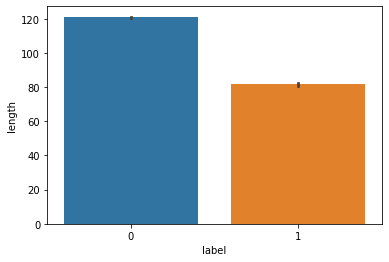

In [223]:
ax = sns.barplot(x="label", y="length", data=testing)

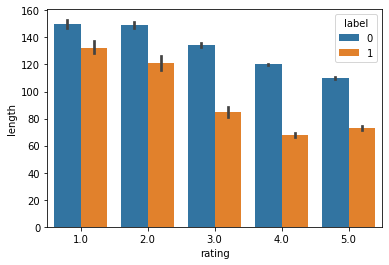

In [224]:
ax = sns.barplot(x="rating", y="length", hue="label", data=testing)

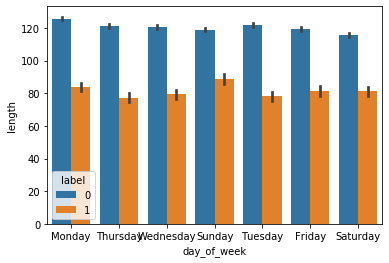

In [225]:
ax = sns.barplot(x="day_of_week", y="length", hue="label", data=testing)

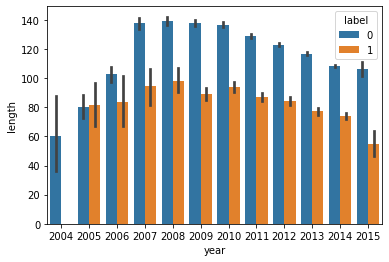

In [226]:
ax = sns.barplot(x="year", y="length", hue="label", data=testing)

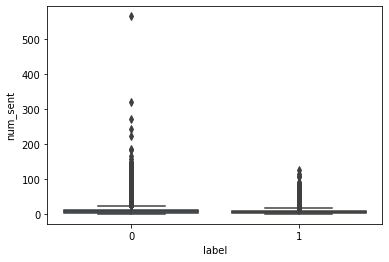

In [227]:
#number of sentences
ax = sns.boxplot(x="label", y="num_sent", data=testing)

In [ ]:
#word2vec visualization
#scatter plot or line plot 

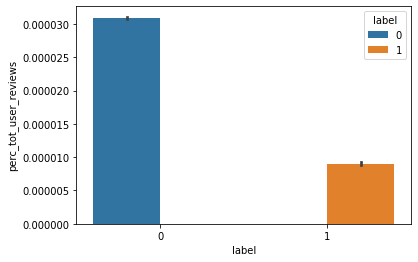

In [218]:
#percent of total user reviews
ax = sns.barplot(x="label", y="perc_tot_user_reviews", hue="label", data=testing)

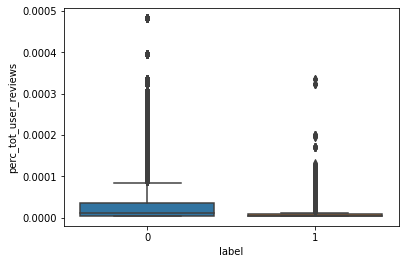

In [219]:
#percent of total user reviews
ax = sns.boxplot(x="label", y="perc_tot_user_reviews", data=testing)

### Imabalanced Classes

SMOTE

### Modeling
Naïve Bayes Classifier, Support Vector
Machines and Logistic Regression classifiers

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve, auc

#L O G I S T I C  R E G R E S S I O N 
#CountVectorizer
countvec_LR_model = LogisticRegression()
countvec_LR_model.fit(X_train_binary, Y_train)
countvec_LR_fpr, countvec_LR_tpr, countvec_LR_thresholds = roc_curve(Y_test, countvec_LR_model.predict_proba(X_test_binary)[:,1])
countvec_LR_auc = auc(countvec_LR_fpr, countvec_LR_tpr)

#TfidfVectorizer
Tfidf_LR_model = LogisticRegression()
Tfidf_LR_model.fit(X_train_binary_Tfidf, Y_train)
Tfidf_LR_fpr, Tfidf_LR_tpr, Tfidf_LR_thresholds = roc_curve(Y_test, Tfidf_LR_model.predict_proba(X_test_binary_Tfidf)[:,1])
Tfidf_LR_auc = auc(Tfidf_LR_fpr, Tfidf_LR_tpr)

#B E R N O U L L I  N B 
#CountVectorizer
countvec_NB_model = BernoulliNB()
countvec_NB_model.fit(X_train_binary, Y_train)
countvec_NB_fpr, countvec_NB_tpr, countvec_NB_thresholds = roc_curve(Y_test, countvec_NB_model.predict_proba(X_test_binary)[:,1])
countvec_NB_auc = auc(countvec_NB_fpr, countvec_NB_tpr)

#TfidfVectorizer
Tfidf_NB_model = BernoulliNB()
Tfidf_NB_model.fit(X_train_binary_Tfidf, Y_train)
Tfidf_NB_fpr, Tfidf_NB_tpr, Tfidf_NB_thresholds = roc_curve(Y_test, Tfidf_NB_model.predict_proba(X_test_binary_Tfidf)[:,1])
Tfidf_NB_auc = auc(Tfidf_NB_fpr, Tfidf_NB_tpr)